# Modeling Credit Risk with Lending Club data

#### Objective: Predict delinquency of a borrower
#### Metric: ROCAUC or PRAUC

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, time, warnings, gzip, gc, random, math, shap, pickle, optuna, csv, sys
from IPython.display import display
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 400)

warnings.filterwarnings("ignore")

In [94]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [115]:
time0 = time.time()

with open('../input/kp102-ds59/LCLoans_59_800k.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)

df.drop(columns = ['pymnt_plan', 'fico_range_low', 'recoveries', 'collection_recovery_fee', 'last_fico_range_low', 'policy_code',
                  'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 
                  'total_rec_late_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high',
                  'collections_12_mths_ex_med', 'acc_now_delinq'],inplace=True)
# fico bucket is always 5 points increment, so I drop lower bound as redundant info
# I drop most of the features above, since they seem to be collected after origination.
display(df.head())
df.drop(columns = ['mths_since_last_record', 'mths_since_last_delinq',
                  'mths_since_last_major_derog'], inplace=True)
# these are useful features, which I will preprocess later
    
df = df.sample(400000)
display(df.shape, time.time()-time0, df.head())

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verification_status_joint,mort_acc,pub_rec_bankruptcies
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1077501,5000,5000,4975.0,36,10.65,162.869995,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,739,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,NaN,Individual,NaN,NaN,NaN,NaN,0.0
1076863,10000,10000,10000.0,36,13.49,339.309998,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,other,personel,917xx,CA,20.00,0.0,Feb-1996,694,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,NaN,Individual,NaN,NaN,NaN,NaN,0.0
1075269,5000,5000,5000.0,36,7.90,156.460007,A,A4,Veolia Transportaton,3 years,RENT,36000.0,Source Verified,Dec-2011,Fully Paid,wedding,My wedding loan I promise to pay back,852xx,AZ,11.20,0.0,Nov-2004,734,3.0,NaN,NaN,9.0,0.0,7963,28.3,12.0,f,NaN,Individual,NaN,NaN,NaN,NaN,0.0
1072053,3000,3000,3000.0,36,18.64,109.430000,E,E1,MKC Accounting,9 years,RENT,48000.0,Source Verified,Dec-2011,Fully Paid,car,Car Downpayment,900xx,CA,5.35,0.0,Jan-2007,664,2.0,NaN,NaN,4.0,0.0,8221,87.5,4.0,f,NaN,Individual,NaN,NaN,NaN,NaN,0.0
1071570,5375,5375,5350.0,60,12.69,121.449997,B,B5,Starbucks,< 1 year,RENT,15000.0,Verified,Dec-2011,Charged Off,other,Building my credit history.,774xx,TX,18.08,0.0,Sep-2004,729,0.0,NaN,NaN,2.0,0.0,9279,36.5,3.0,f,NaN,Individual,NaN,NaN,NaN,NaN,0.0


(400000, 36)

0.5410604476928711

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,annual_inc_joint,dti_joint,verification_status_joint,mort_acc,pub_rec_bankruptcies
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
57649709,10000,10000,10000.0,36,14.65,344.950012,C,C5,Teacher,3 years,RENT,57000.0,Verified,Aug-2015,Fully Paid,small_business,Business,208xx,MD,11.160000,0.0,Oct-1993,664,0.0,4.0,0.0,1252,16.7,28.0,f,Individual,NaN,NaN,NaN,5.0,0.0
170032978,2000,2000,2000.0,36,9.02,63.619999,A,A2,receptionist,10+ years,MORTGAGE,43000.0,Not Verified,Aug-2020,Current,debt_consolidation,Debt consolidation,430xx,OH,17.389999,0.0,Dec-1993,689,1.0,16.0,1.0,8569,22.7,28.0,w,Individual,NaN,NaN,NaN,1.0,1.0
149369687,12600,12600,12600.0,36,7.02,389.170013,A,A2,Head Baseball Coach,10+ years,RENT,50000.0,Source Verified,Mar-2019,Fully Paid,debt_consolidation,Debt consolidation,731xx,OK,10.010000,0.0,Apr-1999,744,0.0,6.0,0.0,3972,45.1,13.0,w,Individual,NaN,NaN,NaN,0.0,0.0
46104267,9625,9625,9625.0,36,13.33,325.839996,C,C3,Inventory/Purchasing Manager,8 years,MORTGAGE,45000.0,Verified,Apr-2015,Fully Paid,debt_consolidation,Debt consolidation,273xx,NC,25.650000,0.0,Sep-1991,709,2.0,12.0,0.0,10386,61.0,26.0,w,Individual,NaN,NaN,NaN,3.0,0.0
157304364,15000,15000,15000.0,36,11.02,491.230011,B,B2,Hvac tech,3 years,MORTGAGE,65000.0,Verified,Sep-2019,Current,other,Other,730xx,OK,20.430000,0.0,Jun-2015,754,0.0,6.0,0.0,367,4.6,11.0,w,Individual,NaN,NaN,NaN,0.0,0.0


In [116]:
# clean time features

df.issue_d = df.issue_d.astype('O')
df.earliest_cr_line = df.earliest_cr_line.astype('O')
df.issue_d = pd.to_datetime(df.issue_d, format='%b-%Y')
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line, format='%b-%Y')
df['year_issued']=df.issue_d.dt.year
df['month_issued']=df.issue_d.dt.month
df['years_borrowing'] = (df.issue_d - df.earliest_cr_line)/ np.timedelta64(1, 'Y')
display(df.head())

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,annual_inc_joint,dti_joint,verification_status_joint,mort_acc,pub_rec_bankruptcies,year,month,years_borrowing
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
57649709,10000,10000,10000.0,36,14.65,344.950012,C,C5,Teacher,3 years,RENT,57000.0,Verified,2015-08-01,Fully Paid,small_business,Business,208xx,MD,11.160000,0.0,1993-10-01,664,0.0,4.0,0.0,1252,16.7,28.0,f,Individual,NaN,NaN,NaN,5.0,0.0,2015,8,21.832070
170032978,2000,2000,2000.0,36,9.02,63.619999,A,A2,receptionist,10+ years,MORTGAGE,43000.0,Not Verified,2020-08-01,Current,debt_consolidation,Debt consolidation,430xx,OH,17.389999,0.0,1993-12-01,689,1.0,16.0,1.0,8569,22.7,28.0,w,Individual,NaN,NaN,NaN,1.0,1.0,2020,8,26.667214
149369687,12600,12600,12600.0,36,7.02,389.170013,A,A2,Head Baseball Coach,10+ years,RENT,50000.0,Source Verified,2019-03-01,Fully Paid,debt_consolidation,Debt consolidation,731xx,OK,10.010000,0.0,1999-04-01,744,0.0,6.0,0.0,3972,45.1,13.0,w,Individual,NaN,NaN,NaN,0.0,0.0,2019,3,19.915536
46104267,9625,9625,9625.0,36,13.33,325.839996,C,C3,Inventory/Purchasing Manager,8 years,MORTGAGE,45000.0,Verified,2015-04-01,Fully Paid,debt_consolidation,Debt consolidation,273xx,NC,25.650000,0.0,1991-09-01,709,2.0,12.0,0.0,10386,61.0,26.0,w,Individual,NaN,NaN,NaN,3.0,0.0,2015,4,23.581593
157304364,15000,15000,15000.0,36,11.02,491.230011,B,B2,Hvac tech,3 years,MORTGAGE,65000.0,Verified,2019-09-01,Current,other,Other,730xx,OK,20.430000,0.0,2015-06-01,754,0.0,6.0,0.0,367,4.6,11.0,w,Individual,NaN,NaN,NaN,0.0,0.0,2019,9,4.251970


In [72]:
display(df.loan_status.value_counts())
df.target=np.nan
df.loc[df.loan_status.isin(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']), 'target']=0
df.loc[df.loan_status.isin(['Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default']), 'target']=1
df=df[df['target'].isin([0,1])]
display(df.shape,df.loan_status.value_counts(), df.count(), sys.getsizeof(df)/1048576)
df.drop(columns='loan_status',inplace=True)

Fully Paid                                             204855
Current                                                140837
Charged Off                                             49703
Late (31-120 days)                                       2141
In Grace Period                                          1333
Late (16-30 days)                                         389
Issued                                                    298
Does not meet the credit policy. Status:Fully Paid        271
Does not meet the credit policy. Status:Charged Off       100
Default                                                    73
Name: loan_status, dtype: int64

(257143, 35)

Fully Paid                                             204855
Charged Off                                             49703
Late (31-120 days)                                       2141
Does not meet the credit policy. Status:Fully Paid        271
Does not meet the credit policy. Status:Charged Off       100
Default                                                    73
Current                                                     0
In Grace Period                                             0
Issued                                                      0
Late (16-30 days)                                           0
Name: loan_status, dtype: int64

loan_amnt                    257143
funded_amnt                  257143
funded_amnt_inv              257143
term                         257143
int_rate                     257143
installment                  257143
grade                        257143
sub_grade                    257143
emp_title                    238829
emp_length                   240908
home_ownership               257143
annual_inc                   257143
verification_status          257143
loan_status                  257143
purpose                      257143
title                        254195
zip_code                     257143
addr_state                   257143
dti                          256976
delinq_2yrs                  257139
fico_range_high              257143
inq_last_6mths               257139
open_acc                     257139
pub_rec                      257139
revol_bal                    257143
revol_util                   256932
total_acc                    257139
initial_list_status         

54.31637763977051

### Feature Preprocessing

In [73]:
# add key loan features
df.loc[df.annual_inc<1,'annual_inc']=1
df['lti']=df.loan_amnt/df.annual_inc
df['iti']=(df.installment*12)/df.annual_inc
df.loc[df.lti==np.inf, 'lti']=np.nan
df.loc[df.lti>2, 'lti']=2
df.loc[df.iti==np.inf, 'iti']=np.nan
df.loc[df.iti>1, 'iti']=1
df.loc[df.revol_util>100,'revol_util']=100

df['zip_code'] = df.zip_code.str.rstrip('xx').astype(int)
df['joint'] = df.dti_joint.notnull().astype(int)

df['emp_length'] = df.emp_length.str.rstrip(' years')
df.loc[df.emp_length=='< 1','emp_length'] = 0
df.loc[df.emp_length=='10+','emp_length'] = 10
df['emp_length'] = df.emp_length.astype(np.float32)
display(df.emp_length.value_counts())

df.drop(columns = ['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'earliest_cr_line', 'issue_d'], inplace=True)

10.0    84061
2.0     23576
0.0     21317
3.0     20820
1.0     16955
5.0     15982
4.0     15547
6.0     11746
8.0     10839
7.0     10741
9.0      9324
Name: emp_length, dtype: int64

In [74]:
df.target.mean()

0.20228822095098836

In [75]:
train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,verification_status,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,target,lti,iti,joint,grade_encoded,sub_grade_encoded,emp_title_encoded,home_ownership_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded
0,10000,10000,10000.0,36,9.71,321.320007,5.0,100000.0,Not Verified,3.910000,0.0,709,1.0,7.0,0.0,10192,56.9,15.0,w,Individual,0.0,0.100000,0.038558,0,0.142470,0.107643,0.201759,0.174601,0.176965,0.131184,0.213967,0.210056
2,10000,10000,10000.0,36,9.49,320.290009,0.0,35000.0,Verified,27.330000,0.0,719,1.0,21.0,1.0,13861,29.6,29.0,f,Individual,0.0,0.285714,0.109814,0,0.142470,0.127953,0.274454,0.174601,0.212042,0.216460,0.187350,0.223538
4,7000,7000,7000.0,36,18.25,253.949997,2.0,43000.0,Source Verified,29.250000,0.0,669,1.0,8.0,2.0,13281,77.2,28.0,w,Individual,1.0,0.162791,0.070870,0,0.311617,0.313386,0.201759,0.233494,0.212483,0.214930,0.263526,0.201793
6,12000,12000,12000.0,36,11.80,397.429993,10.0,30480.0,Verified,45.869999,0.0,694,1.0,10.0,0.0,9376,41.9,41.0,w,Joint App,0.0,0.393701,0.156469,1,0.142470,0.156756,0.178201,0.233494,0.176965,0.181912,0.190546,0.226750
7,7000,7000,7000.0,36,19.99,260.109985,2.0,40000.0,Source Verified,10.360000,0.0,664,0.0,9.0,0.0,11732,65.9,16.0,f,Individual,0.0,0.175000,0.078033,0,0.311617,0.322179,0.251466,0.208926,0.212042,0.216460,0.106967,0.209738


In [76]:
cat_features_te = ['grade', 'sub_grade', 'emp_title', 'home_ownership', 'purpose', 'title', 'zip_code', 'addr_state']
cat_features_ohe = ['verification_status', 'initial_list_status', 'application_type']

In [77]:
df.application_type.value_counts()

Individual    247474
Joint App       9669
Name: application_type, dtype: int64

### EDA

In [78]:
display(df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv']].describe())
# basically, the three features are identical

display(df.term.value_counts())

,loan_amnt,funded_amnt,funded_amnt_inv
count,257143.000000,257143.000000,257143.000000
mean,14608.396593,14600.985347,14579.168945
std,8988.367657,8984.902675,8988.792969
min,500.000000,500.000000,0.000000
25%,8000.000000,7975.000000,7850.000000
50%,12000.000000,12000.000000,12000.000000
75%,20000.000000,20000.000000,20000.000000
max,40000.000000,40000.000000,40000.000000


36    192564
60     64579
Name: term, dtype: int64

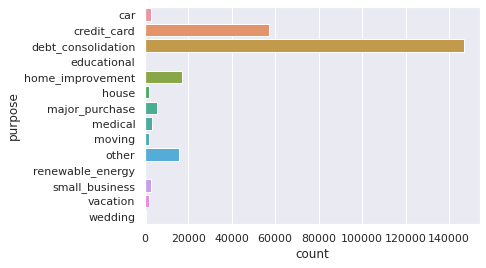

<AxesSubplot:xlabel='count', ylabel='emp_length'>

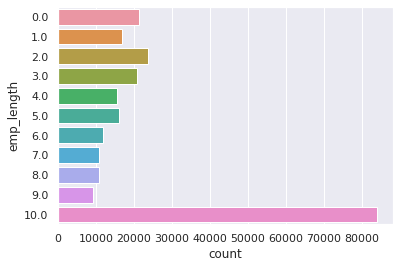

In [79]:
sns.countplot(y='purpose', data=df)
plt.show()
sns.countplot(y='emp_length', data=df)

In [80]:
#top_titles = (df.title.value_counts()[:10]).index
#tempdf = df[df.title.isin(list(top_titles))]
#sns.countplot(y='title', data=tempdf)

In [81]:
display(df.loc[df.target==1,'delinq_2yrs'].describe())
display(df.loc[df.target==0,'delinq_2yrs'].describe())
# i am not sure how this variable is defined. Is it at the moment of loan origination?

count    52017.000000
mean         0.335486
std          0.908774
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         18.000000
Name: delinq_2yrs, dtype: float64

count    205122.000000
mean          0.304243
std           0.850448
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          30.000000
Name: delinq_2yrs, dtype: float64

In [82]:
#df[['fico_range_low', 'fico_range_high']].drop_duplicates().sort_values(['fico_range_low'])

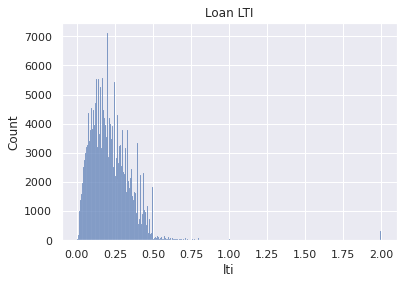

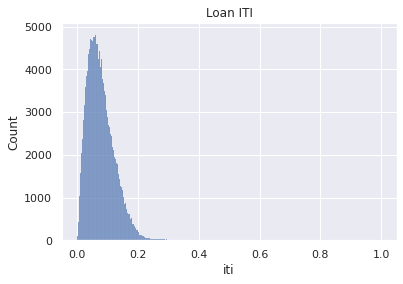

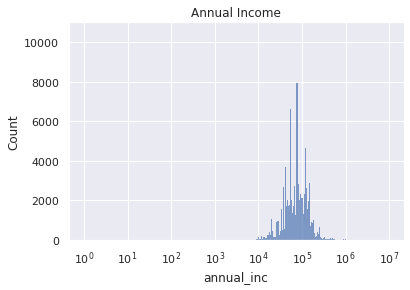

In [83]:
sns.histplot(x='int_rate', data=df).set(title='Loan LTI')
plt.show()
sns.histplot(x='lti', data=df).set(title='Loan LTI')
plt.show()
sns.histplot(x='iti', data=df).set(title='Loan ITI')
plt.show()
sns.histplot(x='annual_inc', data=df, log_scale=True).set(title='Annual Income')
plt.show()

[Text(0.5, 1.0, 'Loan Grade')]

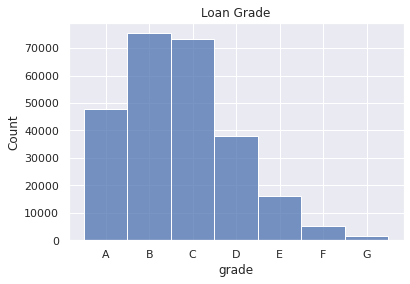

In [84]:
sns.histplot(x='grade', data=df).set(title='Loan Grade')

### EDA with target

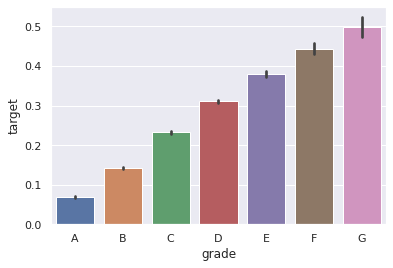

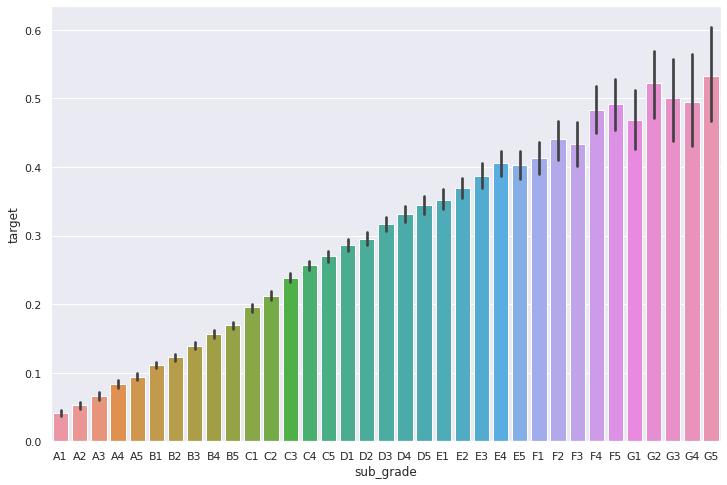

In [85]:
sns.barplot(x='grade', y='target', data=df)
plt.show()
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x='sub_grade', y='target', data=df)
plt.show()
sns.barplot(x='purpose', y='target', data=df)
plt.show()

### Train-test split, missing values

In [86]:
display(df.count())

loan_amnt               257143
funded_amnt             257143
funded_amnt_inv         257143
term                    257143
int_rate                257143
installment             257143
grade                   257143
sub_grade               257143
emp_title               238829
emp_length              240908
home_ownership          257143
annual_inc              257143
verification_status     257143
purpose                 257143
title                   254195
zip_code                257143
addr_state              257143
dti                     256976
delinq_2yrs             257139
fico_range_high         257143
inq_last_6mths          257139
open_acc                257139
pub_rec                 257139
revol_bal               257143
revol_util              256932
total_acc               257139
initial_list_status     257143
application_type        257143
mort_acc                250202
pub_rec_bankruptcies    256946
target                  257143
lti                     257143
iti     

In [87]:
features_fill_M = ['emp_title', 'title']
features_fill_med = ['dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']

df['emp_length'] = df['emp_length'].fillna(value=0)

for col in features_fill_M:
    df[col] = df[col].cat.add_categories(['MISSING']) 
    df[col] = df[col].fillna(value='MISSING')

test_size = 0.1
df.reset_index(inplace=True, drop=True)
test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
train = df.iloc[list(set(df.index)-set(test_index))]
test = df.iloc[test_index]
display(train.shape, test.shape, train.head(3), test.head(3))

for col in features_fill_med:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())

display(train.count(), test.count())

(231429, 34)

(25714, 34)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,target,lti,iti,joint
1,7000,7000,7000.0,36,15.61,244.759995,D,D1,veterinarians assistant,7.0,RENT,26000.0,Not Verified,debt_consolidation,Debt consolidation,120,NY,12.14,0.0,664,0.0,6.0,0.0,7759,68.1,6.0,w,Individual,0.0,0.0,0.0,0.269231,0.112966,0
2,1000,1000,1000.0,36,12.74,33.570000,C,C1,MISSING,0.0,RENT,28620.0,Verified,other,Other,88,NJ,16.90,1.0,689,1.0,5.0,0.0,2078,33.5,23.0,w,Individual,0.0,0.0,0.0,0.034941,0.014075,0
3,35000,35000,35000.0,36,7.89,1095.000000,A,A5,Pilot,4.0,MORTGAGE,130000.0,Source Verified,debt_consolidation,Debt consolidation,180,PA,19.07,0.0,754,0.0,5.0,0.0,23017,68.1,14.0,w,Individual,1.0,0.0,0.0,0.269231,0.101077,0


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,target,lti,iti,joint
228167,7500,7500,7500.0,36,16.91,267.059998,C,C5,customer service,2.0,MORTGAGE,30000.0,Source Verified,debt_consolidation,Debt consolidation,601,IL,2.48,0.0,674,0.0,4.0,0.0,1351,38.6,9.0,w,Individual,2.0,0.0,1.0,0.250000,0.106824,0
97530,10000,10000,10000.0,36,16.12,352.170013,C,C3,Systems Technician,3.0,RENT,62000.0,Source Verified,debt_consolidation,Debt consolidation,18,MA,8.38,0.0,669,0.0,8.0,0.0,3122,55.8,12.0,w,Individual,0.0,0.0,0.0,0.161290,0.068162,0
77741,12000,12000,12000.0,36,24.74,475.470001,E,E3,Store Leader,8.0,MORTGAGE,79762.0,Not Verified,debt_consolidation,Debt consolidation,300,GA,9.60,0.0,714,5.0,11.0,0.0,7997,29.7,21.0,f,Individual,1.0,0.0,1.0,0.150448,0.071533,0


loan_amnt               231429
funded_amnt             231429
funded_amnt_inv         231429
term                    231429
int_rate                231429
installment             231429
grade                   231429
sub_grade               231429
emp_title               231429
emp_length              231429
home_ownership          231429
annual_inc              231429
verification_status     231429
purpose                 231429
title                   231429
zip_code                231429
addr_state              231429
dti                     231429
delinq_2yrs             231429
fico_range_high         231429
inq_last_6mths          231429
open_acc                231429
pub_rec                 231429
revol_bal               231429
revol_util              231429
total_acc               231429
initial_list_status     231429
application_type        231429
mort_acc                231429
pub_rec_bankruptcies    231429
target                  231429
lti                     231429
iti     

loan_amnt               25714
funded_amnt             25714
funded_amnt_inv         25714
term                    25714
int_rate                25714
installment             25714
grade                   25714
sub_grade               25714
emp_title               25714
emp_length              25714
home_ownership          25714
annual_inc              25714
verification_status     25714
purpose                 25714
title                   25714
zip_code                25714
addr_state              25714
dti                     25714
delinq_2yrs             25714
fico_range_high         25714
inq_last_6mths          25714
open_acc                25714
pub_rec                 25714
revol_bal               25714
revol_util              25714
total_acc               25714
initial_list_status     25714
application_type        25714
mort_acc                25714
pub_rec_bankruptcies    25714
target                  25714
lti                     25714
iti                     25714
joint     

### Categorical features encoding

In [88]:
# TE for categorical features

time1 = time.time()
encoder = CrossFoldEncoder(MEstimateEncoder, m=10)
train_encoded = encoder.fit_transform(train, train.target, cols=cat_features_te)
test_encoded = encoder.transform(test)

train.drop(columns=cat_features_te, inplace=True)
test.drop(columns=cat_features_te,  inplace=True)
train = pd.concat([train, train_encoded], axis = 1)
test = pd.concat([test, test_encoded], axis = 1)

display(time.time()-time0, time.time()-time1)
display(train.shape, train.head(), train.count())
train0 = train.copy()
test0 = test.copy()

19.312870502471924

5.274432897567749

(231429, 34)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,verification_status,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,target,lti,iti,joint,grade_encoded,sub_grade_encoded,emp_title_encoded,home_ownership_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded
1,7000,7000,7000.0,36,15.61,244.759995,7.0,26000.0,Not Verified,12.14,0.0,664,0.0,6.0,0.0,7759,68.1,6.0,w,Individual,0.0,0.0,0.0,0.269231,0.112966,0,0.312037,0.287758,0.202326,0.233339,0.213696,0.218470,0.195403,0.223488
2,1000,1000,1000.0,36,12.74,33.570000,0.0,28620.0,Verified,16.90,1.0,689,1.0,5.0,0.0,2078,33.5,23.0,w,Individual,0.0,0.0,0.0,0.034941,0.014075,0,0.231699,0.190938,0.279940,0.233339,0.210006,0.214042,0.192752,0.207806
3,35000,35000,35000.0,36,7.89,1095.000000,4.0,130000.0,Source Verified,19.07,0.0,754,0.0,5.0,0.0,23017,68.1,14.0,w,Individual,1.0,0.0,0.0,0.269231,0.101077,0,0.070484,0.096147,0.158915,0.175187,0.213696,0.218470,0.232683,0.201033
4,20000,20000,20000.0,36,14.09,684.429993,0.0,64000.0,Verified,19.33,0.0,714,1.0,9.0,0.0,19483,59.0,11.0,f,Individual,0.0,0.0,0.0,0.312500,0.128331,0,0.141461,0.168570,0.167959,0.175187,0.213696,0.123333,0.190412,0.199749
5,5000,5000,5000.0,36,5.32,150.580002,3.0,42000.0,Not Verified,3.51,0.0,744,0.0,7.0,0.0,4149,9.4,14.0,w,Individual,0.0,0.0,1.0,0.119048,0.043023,0,0.070484,0.040120,0.274842,0.175187,0.213696,0.218470,0.193473,0.159403


loan_amnt                 231429
funded_amnt               231429
funded_amnt_inv           231429
term                      231429
int_rate                  231429
installment               231429
emp_length                231429
annual_inc                231429
verification_status       231429
dti                       231429
delinq_2yrs               231429
fico_range_high           231429
inq_last_6mths            231429
open_acc                  231429
pub_rec                   231429
revol_bal                 231429
revol_util                231429
total_acc                 231429
initial_list_status       231429
application_type          231429
mort_acc                  231429
pub_rec_bankruptcies      231429
target                    231429
lti                       231429
iti                       231429
joint                     231429
grade_encoded             231429
sub_grade_encoded         231429
emp_title_encoded         231429
home_ownership_encoded    231429
purpose_en

In [89]:
X_train = train.copy()
y_train = X_train.pop('target')
X_test = test.copy()
y_test = X_test.pop('target')
display(X_test.head())

### Do OHE for some features ###

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore"), cat_features_ohe)], remainder="passthrough")

print('Number of features before transaformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transaformation: ', X_train.shape)
X_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,verification_status,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,lti,iti,joint,grade_encoded,sub_grade_encoded,emp_title_encoded,home_ownership_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded
228167,7500,7500,7500.0,36,16.91,267.059998,2.0,30000.0,Source Verified,2.480000,0.0,674,0.0,4.0,0.0,1351,38.6,9.0,w,Individual,2.0,0.0,0.250000,0.106824,0,0.232195,0.268117,0.220103,0.175582,0.214088,0.219051,0.213691,0.186000
97530,10000,10000,10000.0,36,16.12,352.170013,3.0,62000.0,Source Verified,8.380000,0.0,669,0.0,8.0,0.0,3122,55.8,12.0,w,Individual,0.0,0.0,0.161290,0.068162,0,0.232195,0.238363,0.202529,0.233381,0.214088,0.219051,0.205118,0.194119
77741,12000,12000,12000.0,36,24.74,475.470001,8.0,79762.0,Not Verified,9.600000,0.0,714,5.0,11.0,0.0,7997,29.7,21.0,f,Individual,1.0,0.0,0.150448,0.071533,0,0.381197,0.391042,0.211553,0.175582,0.214088,0.219051,0.177370,0.190271
149494,15000,15000,15000.0,36,7.84,468.940002,10.0,89000.0,Source Verified,4.260000,0.0,724,2.0,9.0,0.0,17121,21.7,48.0,w,Individual,4.0,0.0,0.168539,0.063228,0,0.070611,0.085329,0.089344,0.175582,0.214088,0.219051,0.237722,0.201447
113598,10500,10500,10500.0,36,16.99,374.309998,0.0,36000.0,Verified,33.529999,0.0,664,3.0,6.0,0.0,3462,28.8,11.0,f,Individual,0.0,0.0,0.291667,0.124770,0,0.311597,0.315906,0.278662,0.233381,0.214088,0.219051,0.228028,0.231510


Number of features before transaformation:  (231429, 33)
time to do feature proprocessing:  5.712433099746704
Number of features after transaformation:  (231429, 37)


,cat__verification_status_Not Verified,cat__verification_status_Source Verified,cat__verification_status_Verified,cat__initial_list_status_f,cat__initial_list_status_w,cat__application_type_Individual,cat__application_type_Joint App,remainder__loan_amnt,remainder__funded_amnt,remainder__funded_amnt_inv,remainder__term,remainder__int_rate,remainder__installment,remainder__emp_length,remainder__annual_inc,remainder__dti,remainder__delinq_2yrs,remainder__fico_range_high,remainder__inq_last_6mths,remainder__open_acc,remainder__pub_rec,remainder__revol_bal,remainder__revol_util,remainder__total_acc,remainder__mort_acc,remainder__pub_rec_bankruptcies,remainder__lti,remainder__iti,remainder__joint,remainder__grade_encoded,remainder__sub_grade_encoded,remainder__emp_title_encoded,remainder__home_ownership_encoded,remainder__purpose_encoded,remainder__title_encoded,remainder__zip_code_encoded,remainder__addr_state_encoded
0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,7000.0,7000.0,7000.0,36.0,15.61,244.759995,7.0,26000.0,12.14,0.0,664.0,0.0,6.0,0.0,7759.0,68.1,6.0,0.0,0.0,0.269231,0.112966,0.0,0.312037,0.287758,0.202326,0.233339,0.213696,0.218470,0.195403,0.223488
1,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1000.0,1000.0,1000.0,36.0,12.74,33.570000,0.0,28620.0,16.90,1.0,689.0,1.0,5.0,0.0,2078.0,33.5,23.0,0.0,0.0,0.034941,0.014075,0.0,0.231699,0.190938,0.279940,0.233339,0.210006,0.214042,0.192752,0.207806
2,0.0,1.0,0.0,0.0,1.0,1.0,0.0,35000.0,35000.0,35000.0,36.0,7.89,1095.000000,4.0,130000.0,19.07,0.0,754.0,0.0,5.0,0.0,23017.0,68.1,14.0,1.0,0.0,0.269231,0.101077,0.0,0.070484,0.096147,0.158915,0.175187,0.213696,0.218470,0.232683,0.201033
3,0.0,0.0,1.0,1.0,0.0,1.0,0.0,20000.0,20000.0,20000.0,36.0,14.09,684.429993,0.0,64000.0,19.33,0.0,714.0,1.0,9.0,0.0,19483.0,59.0,11.0,0.0,0.0,0.312500,0.128331,0.0,0.141461,0.168570,0.167959,0.175187,0.213696,0.123333,0.190412,0.199749
4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,5000.0,5000.0,5000.0,36.0,5.32,150.580002,3.0,42000.0,3.51,0.0,744.0,0.0,7.0,0.0,4149.0,9.4,14.0,0.0,0.0,0.119048,0.043023,0.0,0.070484,0.040120,0.274842,0.175187,0.213696,0.218470,0.193473,0.159403


### Modeling

In [90]:
time1 = time.time()
xgb = XGBClassifier(tree_method = 'gpu_hist')
xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]
precision_t, recall_t, threshold = precision_recall_curve(y_test, xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

display('Train Accuracy: ', accuracy_score(y_train,xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)

# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

'Train Accuracy: '

0.8163151549719352

'F1 score: '

0.2493112947658402

'ROCAUC: '

0.5679930704823888

'PRAUC: '

0.5137098461404198

'R20P: '

0.6784938450398262

'Test Accuracy: '

0.8024422493583262

'F1 score: '

0.17612714888096012

'ROCAUC: '

0.5411637421821891

'PRAUC: '

0.3771217331375663

'R20P: '

0.47759815242494225

3.7913198471069336

In [91]:
### Fit XGBoost using Optuna hyperparameter optimization ###

def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1, scale_pos_weight=1):

    cv_regularizer=0.05
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 300, 700),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.01, 0.4),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 150.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
        "n_jobs": n_jobs,
    }
    # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
    # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
    # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

    temp_out = []

    for i in range(cv_runs):

        X = X_train
        y = y_train

        model = XGBClassifier(**params)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] += model.predict(X_B)
            y_pred_train[train_index] += model.predict(X_A)
        score_train = roc_auc_score(y_train, y_pred_train)
        score_test = roc_auc_score(y_train, y_pred) 
        overfit = score_train-score_test
        #return (score_test)
        #return (score_test-cv_regularizer*overfit)
        temp_out.append(score_test-cv_regularizer*overfit)

    return (np.mean(temp_out))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'
optuna_hyperpars['scale_pos_weight']=1

optuna_xgb = XGBClassifier(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, optuna_xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]
precision_t, recall_t, threshold = precision_recall_curve(y_test, optuna_xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

display('Train Accuracy: ', accuracy_score(y_train,optuna_xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,optuna_xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,optuna_xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)
# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,optuna_xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,optuna_xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,optuna_xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

[I 2022-08-07 23:27:56,110] A new study created in memory with name: no-name-948293d9-2df0-4097-ba8d-db9a56c08c4d
[I 2022-08-07 23:28:39,102] Trial 0 finished with value: 0.5339275560804464 and parameters: {'n_estimators': 688, 'max_depth': 10, 'learning_rate': 0.21619231519413243, 'colsample_bytree': 0.447748763279729, 'subsample': 0.6216744297905383, 'alpha': 8.721198844355728, 'lambda': 0.13558366668376506, 'gamma': 0.038194296393353915, 'min_child_weight': 0.3652256757195309}. Best is trial 0 with value: 0.5339275560804464.
[I 2022-08-07 23:28:42,938] Trial 1 finished with value: 0.5278513688065335 and parameters: {'n_estimators': 503, 'max_depth': 2, 'learning_rate': 0.05866274844310411, 'colsample_bytree': 0.2509161682286284, 'subsample': 0.7350835361589876, 'alpha': 2.560291785184102, 'lambda': 0.3334314115282348, 'gamma': 1.831252192544373e-05, 'min_child_weight': 0.10783414587949267}. Best is trial 0 with value: 0.5339275560804464.
[I 2022-08-07 23:29:00,281] Trial 2 finished 

Total time for hypermarameter optimization  381.94447231292725
        n_estimators : 371
           max_depth : 6
       learning_rate : 0.3698256343869829
    colsample_bytree : 0.4917360826711413
           subsample : 0.775215628924792
               alpha : 5.301640480647502
              lambda : 0.6306956643832147
               gamma : 9.543092397276484e-07
    min_child_weight : 0.5106658445412703
best objective value : 0.545056558649996


'Train Accuracy: '

0.8429064637534622

'F1 score: '

0.4243278335497355

'ROCAUC: '

0.635121601819451

'PRAUC: '

0.664749709425118

'R20P: '

0.874207385303991

'Test Accuracy: '

0.7941977133079257

'F1 score: '

0.20802155043400178

'ROCAUC: '

0.5470837976062038

'PRAUC: '

0.3504633673691016

'R20P: '

0.4231085526315789

392.9716284275055

In [92]:
time.time()-time0

412.78515887260437